## Lahman's Baseball Database

We'll use SQL and python libraries to explore data in [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/), which contains "complete batting and pitching statistics from 1871 to 2018, plus fielding statistics, standings, team stats, managerial records, post-season data, and more."

You can download the database in SQLite format [HERE](https://anson.ucdavis.edu/~nulle/baseball.sqlite).

We look to answer the following questions with our database.

1. From 2006 to 2016, which 5 teams had the highest payrolls? Payroll means the sum of the salaries for all people on the team in a given year.

2. Is there any general trend in payrolls over this time period?

3. There are at least 2 anomalies in the payrolls over this time period. What are they, and can you find information (online or elsewhere) to explain them?

4. How do the top 5 teams compare to other teams?

In [3]:
import pandas as pd
import numpy as np

import sqlite3 as sql

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
%matplotlib inline

file = 'baseball.sqlite'
db = sql.connect(file)

,club,net_salary
0,New York Yankees,2263671350
1,Boston Red Sox,1675457587
2,Los Angeles Dodgers,1598052605
3,Detroit Tigers,1457054966
4,Philadelphia Phillies,1399510324


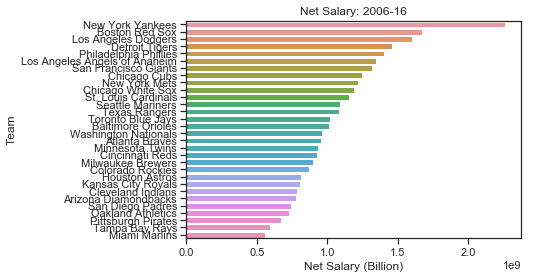

In [4]:
net_sal = pd.read_sql("""
SELECT q2.club, q1.net_salary FROM (
    SELECT SUM(s.salary) AS net_salary, s.teamID FROM (SELECT salary, yearID, REPLACE(teamID, 'FLO','MIA') AS teamID FROM salaries) AS s 
    WHERE s.yearID BETWEEN 2006 AND 2016 GROUP BY s.teamID) as q1
JOIN (
    SELECT DISTINCT REPLACE(teamID, 'FLO','MIA') AS teamID, REPLACE(REPLACE(REPLACE(name,'Tampa Bay Devil Rays','Tampa Bay Rays'),'Anaheim Angels','Los Angeles Angels of Anaheim'),'Florida','Miami') AS club
    FROM teams WHERE yearID BETWEEN 2006 AND 2016
) AS q2 ON q1.teamID = q2.teamID ORDER BY q1.net_salary DESC
""",db)

ax = sns.barplot('net_salary','club', data=net_sal)
ax.set_title('Net Salary: 2006-16')
ax.set_ylabel('Team')
ax.set_xlabel('Net Salary (Billion)')
net_sal.head()

We look at the top 5 payrolls, net, over the years 2006 to 2016. We Can see a fairly steady increase from the bottom spenders to the top, with the exception of the New York Yankees spending far more than all others.

We cleaned up the data by chaning names and tickers of teams that had identification changes over the ten year span (Florida, LA, and TB). These are reflected in the sql query statement. 

The New York Yankees have traditionally spent far more than all other clubs, with the rest of the league only catching up in recent years. This peaked in the early 2010's as well, which was when the Yankees had the majority of their expiring contracts from the 2000's. 

We'll look presently at year by year payroll of our top 5 overall spenders over this ten year span to look at any anomolies. 

Link: Marlins History

https://en.wikipedia.org/wiki/History_of_the_Miami_Marlins

Link: NYY Historical Spending

http://riveraveblues.com/2015/11/after-ten-years-yankees-stagnant-payroll-is-an-issue-that-can-no-longer-be-ignored-130705/

Text(43.25931184895835, 0.5, 'Net Salary ($)')

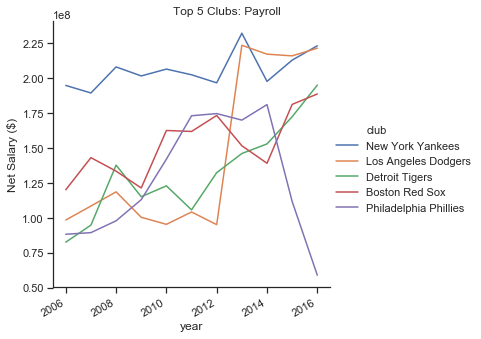

In [11]:
s1 = """
(SELECT cast(sum(salary) as float) as net_salary, yearID, teamID, lgID
FROM salaries
WHERE yearID > 2005
GROUP BY yearID,teamID)
"""

net_sal_ann = pd.read_sql("""
SELECT q2.club, q1.net_salary, q1.yearID AS year FROM (
    SELECT SUM(s.salary) AS net_salary, s.teamID, s.yearID FROM (SELECT salary, yearID, REPLACE(teamID, 'FLO','MIA') AS teamID FROM salaries) AS s 
    WHERE s.yearID BETWEEN 2006 AND 2016 GROUP BY s.yearID,s.teamID) as q1
JOIN (
    SELECT DISTINCT REPLACE(teamID, 'FLO','MIA') AS teamID, REPLACE(REPLACE(REPLACE(name,'Tampa Bay Devil Rays','Tampa Bay Rays'),'Anaheim Angels','Los Angeles Angels of Anaheim'),'Florida','Miami') AS club
    FROM teams WHERE yearID BETWEEN 2006 AND 2016
) AS q2 ON q1.teamID = q2.teamID ORDER BY q1.net_salary DESC
""",db)

top5 = net_sal['club'].values[:5]
df5 = net_sal_ann[net_sal_ann['club'].isin(top5)]

g = sns.relplot('year','net_salary','club', kind='line',data=df5, dashes=False,markers=True)
g.fig.autofmt_xdate()
g.fig.suptitle('Top 5 Clubs: Payroll')
plt.ylabel('Net Salary ($)')

One can see the movement of the top 5 spending franchises and notice the sharp swings in money spent. Of particular note is the LA Dodgers and the Philadelphia Phillies. The Dodgers show a sharp increase in spending from 2012 to 2014, where they've remained constant with the Yankees expenditure. This cause can be traced back to the new ownership of the team and a pledge to contend every year, especially considering the market. In contrast, the Phillies saw a rapid decline in spending from 2013 to 2016, which corresponded to their fall from the annual playoff picture as star players aged and the team began to 'tank'. 

https://www.latimes.com/sports/dodgers/la-sp-dodgers-debt-payroll-20161126-story.html

https://www.beyondtheboxscore.com/2017/1/26/14384012/philadelphia-phillies-collapse-ryan-howard-ruben-amaro-2012-2015

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


Text(43.25931184895835, 0.5, 'Net Salary ($)')

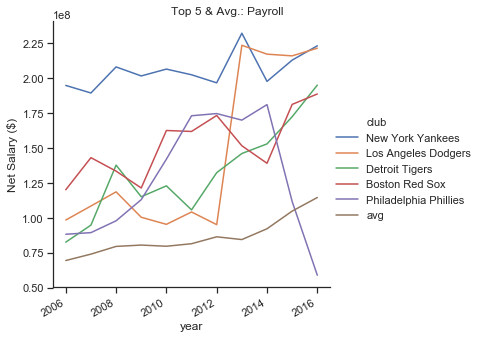

In [13]:
t5 = tuple(top5)

pd.read_sql("""
SELECT AVG(q1.net_salary) AS net_salary, q1.yearID AS year FROM (
    SELECT SUM(s.salary) AS net_salary, s.teamID, s.yearID FROM (SELECT salary, yearID, REPLACE(teamID, 'FLO','MIA') AS teamID FROM salaries) AS s 
    WHERE s.yearID BETWEEN 2006 AND 2016 GROUP BY s.yearID,s.teamID) as q1
JOIN (
    SELECT DISTINCT REPLACE(teamID, 'FLO','MIA') AS teamID, REPLACE(REPLACE(REPLACE(name,'Tampa Bay Devil Rays','Tampa Bay Rays'),'Anaheim Angels','Los Angeles Angels of Anaheim'),'Florida','Miami') AS club
    FROM teams WHERE yearID BETWEEN 2006 AND 2016
) AS q2 ON q1.teamID = q2.teamID WHERE q2.club NOT IN {}ORDER BY q1.net_salary DESC
""".format(t5),db)

avg = pd.read_sql("""
SELECT AVG(q1.net_salary) AS net_salary, q1.yearID AS year FROM (
    SELECT SUM(s.salary) AS net_salary, s.teamID, s.yearID FROM (SELECT salary, yearID, REPLACE(teamID, 'FLO','MIA') AS teamID FROM salaries) AS s 
    WHERE s.yearID BETWEEN 2006 AND 2016 GROUP BY s.yearID,s.teamID) as q1
JOIN (
    SELECT DISTINCT REPLACE(teamID, 'FLO','MIA') AS teamID, REPLACE(REPLACE(REPLACE(name,'Tampa Bay Devil Rays','Tampa Bay Rays'),'Anaheim Angels','Los Angeles Angels of Anaheim'),'Florida','Miami') AS club
    FROM teams WHERE yearID BETWEEN 2006 AND 2016
) AS q2 ON q1.teamID = q2.teamID WHERE q2.club NOT IN {} GROUP BY year
""".format(t5),db)

# createes a 'team' average so that we can plot alongside our top 5 clubs
avg['club'] = 'avg'
df = df5.merge(avg, how='outer')

g = sns.relplot('year','net_salary','club', kind='line',data=df, dashes=False,markers=True)
g.fig.autofmt_xdate()
g.fig.suptitle('Top 5 & Avg.: Payroll')
plt.ylabel('Net Salary ($)')

We can see the relationship between our top 5 spenders and the rest of the league (represented here as avg). With the exception of the phillies, all ourearners consistently spend more than the average, though there is still a marked difference between the teams at the top of the top, though the trend in payroll size is increasing. We will explore further whether this increased purchasing power results in success on the field. 

We begin part two by continuing our analysis of team payroll salaries from part 1. We look at teams expenses (player salaries) versus revenues (ticket sales ~ estimated by the product of total attendance and average ticket price over the ten year span). 

We look at the relationship between on-field success and net income (projected) in terms of Divisional, League, and World Series titles. Does the spending of our top 5 clubs from part 1 pay off in the form of titles?

Note -- We make an approximation for net income by taking the difference between team revenue and team expense. In reality, average ticket sales and player salaries are only a portion of the clubs income statement, though it works as a weak approximation in our case.

In [15]:
# https://www.statista.com/statistics/193426/average-ticket-price-in-the-mlb-since-2006/
# average ticket prices over our 10 year span
avg_tick_price = round(np.average([22.21, 22.27, 25.43, 26.64, 26.74, 26.91, 26.98, 27.48, 27.93, 29.94, 31]),3)

In [16]:
# query for estimated revenue, as well as success in the playoffs
team2 = """
SELECT DISTINCT teamID, wsWin AS WS, 
                lgWin AS LCS, DivWin AS LDS, 
                yearID AS year, attendance*CAST({} as float) AS proj_rev,
                name AS club
FROM teams
WHERE (year BETWEEN 2006 AND 2016)
""".format(avg_tick_price)

# query for the net salaries, yearly by team
sal = """
(SELECT CAST(sum(salary) as float) AS net_salary, 
        yearID AS year, teamID, lgID
FROM salaries
WHERE yearID BETWEEN 2006 AND 2016
GROUP BY yearID, teamID)
"""

# query for the team names, ensure that names are distinct
team1 = """
(SELECT DISTINCT teamID, name AS club
FROM teams
WHERE (lgID = 'AL' OR lgID = 'NL') AND (yearID > 2007))
"""

# query to match net salaries with club names
q1 = """
SELECT *
FROM {} AS s1
INNER JOIN {} AS s2
ON s1.teamID = s2.teamID
""".format(sal,team1)

df = pd.read_sql("""
SELECT q2.proj_rev, q1.net_salary AS proj_exp,
        q2.proj_rev - q1.net_salary AS NET,
        q2.WS, q2.LCS, q2.LDS, q2.year, q2.club
FROM ({}) as q1
INNER JOIN ({}) as q2
ON (q1.year = q2.year) AND (q1.teamID = q2.teamID)
""".format(q1, team2),db)

,proj_rev,proj_exp,NET,year
mean,6.659663e+07,9.720448e+07,-3.060784e+07,2011.00000
std,1.773903e+07,4.132710e+07,3.155883e+07,3.16708
min,3.106492e+07,1.467150e+07,-1.444631e+08,2006.00000
25%,5.288880e+07,6.855761e+07,-4.378603e+07,2008.00000
50%,6.472963e+07,8.891146e+07,-2.306145e+07,2011.00000
75%,8.064670e+07,1.171853e+08,-8.248714e+06,2014.00000
max,1.147096e+08,2.319789e+08,2.618980e+07,2016.00000


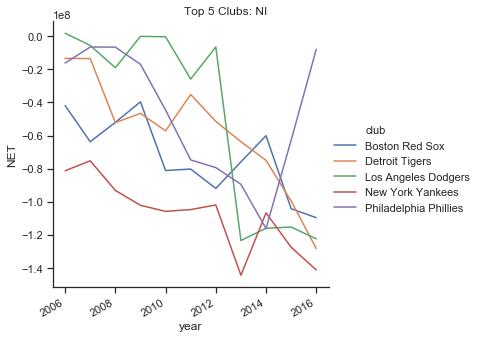

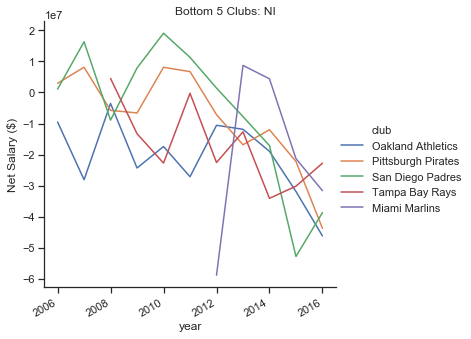

In [17]:
dft5 = df[df['club'].isin(top5)]
bottom5 = net_sal['club'].values[-5:]
dfb5 = df[df['club'].isin(bottom5)]

g1 = sns.relplot('year','NET','club',kind='line',data=dft5)
g2 = sns.relplot('year','NET','club',kind='line',data=dfb5)

g1.fig.suptitle('Top 5 Clubs: NI')
g1.fig.autofmt_xdate()
g2.fig.suptitle('Bottom 5 Clubs: NI')
g2.fig.autofmt_xdate()
plt.ylabel('Net Salary ($)')

df.describe()[1:]

,club,World,Championship,Divisional
0,San Francisco Giants,3,3,2
1,Boston Red Sox,2,2,3
2,St. Louis Cardinals,2,3,5
3,Chicago Cubs,1,1,3
4,Kansas City Royals,1,2,1


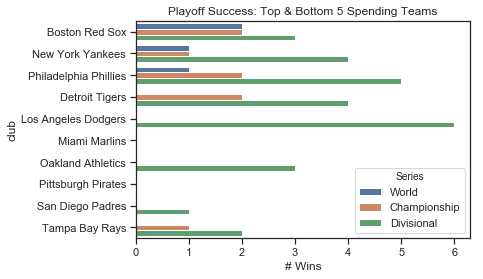

In [18]:
playoff_success = pd.read_sql("""
WITH query AS ({})

SELECT t1.club, SUM(t1.ws) AS World,
            SUM(t1.lcs) AS Championship,
            SUM(t1.lds) AS Divisional
FROM(SELECT club, year,
    CASE WHEN WS == 'Y' THEN 1 ELSE 0 END AS ws,
    CASE WHEN LCS == 'Y' THEN 1 ELSE 0 END AS lcs,
    CASE WHEN LDS == 'Y' THEN 1 ELSE 0 END AS lds
FROM query) AS t1
GROUP BY club
ORDER BY World DESC
""".format(team2),db)

# get data into a tidy format for analysis
ps = playoff_success.melt(id_vars='club', var_name='Series',value_name='# Wins')
pst5 = ps[ps['club'].isin(top5)]
psb5 = ps[ps['club'].isin(bottom5)]
ps = pst5.merge(psb5, how='outer')

ax = sns.barplot('# Wins','club','Series',data=ps)
ax.set_title('Playoff Success: Top & Bottom 5 Spending Teams')
playoff_success.head()

We observe that our top 5 payrolls are consistently below breaking even, though we also observe that the bottom 5 in spending are also below breaking even. On average, clubs spend more on payroll then they take in from ticket revenue (projected). Yet while most clubs seem to be losing money in this department, it looks like the teams that are willing to spend more on players enjoy more post-season success. recognized in divisional, champion and world series titles. The Red Sox, Yankees, and Phillies all show success in the world and championship series while the dodgers have won the division 6 times in the last ten years. 

Incentives for clubs to invest in players, and thus the postseason, revolve around the added revenue one would expect to gain from playing in the postseason slots. While we don't have the necessary data to quantify it, both players and teams have monetary incentives to reach and then perform in the postseason. 

https://www.cnbc.com/2018/10/29/the-red-sox-won-the-world-series-heres-how-much-money-theyll-earn.html

After detailing the incentives that teams have for postseason success, it's now time to analyze ways in which they can reach their goals. We will explore how metrics of past teams postseason success may serve as an indicator of how to construct a winning ball club.

Question: What general metrics, if any, are a good measure of playoff success? Is performance in the regular season indicative of playoff success?

In [9]:
subquery = """
 WITH q1 AS (SELECT DISTINCT REPLACE(REPLACE(teamID,'ANA','LAA'),'FLO','MIA') AS teamID,
                REPLACE(REPLACE(REPLACE(name,'Tampa Bay Devil Rays','Tampa Bay Rays'),'Anaheim Angels','Los Angeles Angels of Anaheim'),'Florida','Miami') AS name,
                yearid AS year,R,RA, ERA, FP,BB,SO, W, L, R-ER AS net_runs,
                AB,H,HR,SB,CS, SF, HA,HRA, BBA,SOA,(W * 1.0/G) AS win_pct,
                CASE WHEN WsWin == 'Y' THEN 1 ELSE 0 END AS ws, 
                CASE WHEN LgWin == 'Y' THEN 1 ELSE 0 END AS lcs,
                CASE WHEN WCWin == 'Y' THEN 1 ELSE 0 END AS wcw,
                CASE WHEN DivWin == 'Y' THEN 1 ELSE 0 END AS dw
                FROM teams WHERE yearID >= 2000),
        q2 AS (SELECT name, year, net_runs, win_pct, ERA, (HR * 1.0 / SO) AS hr_so, (HR * 1.0 / H) as hr_hit,
                (BB/SO) AS walk_so, (H + BB)/AB AS obp, (HRA * 1.0 / (HA+BBA)) AS hra_ha, 
                (SOA * 1.0 / (HA+BBA)) AS so_ha,
                ws, lcs, wcw, dw
                FROM q1),
        q3 AS (SELECT name, year, net_runs, win_pct, ERA, (HR * 1.0 / SO) AS hr_so, (HR * 1.0 / H) as hr_hit,
                (BB/SO) AS walk_so, (H + BB)/AB AS obp, (HRA * 1.0 / (HA+BBA)) AS hra_ha, 
                (SOA * 1.0 / (HA+BBA)) AS so_ha,
                ws, lcs, wcw, dw
                FROM q1 WHERE name == 'San Francisco Giants'),
        q4 AS (SELECT name, year, net_runs, win_pct, ERA, (HR * 1.0 / SO) AS hr_so, (HR * 1.0 / H) as hr_hit,
                (BB/SO) AS walk_so, (H + BB)/AB AS obp, (HRA * 1.0 / (HA+BBA)) AS hra_ha, 
                (SOA * 1.0 / (HA+BBA)) AS so_ha,
                ws, lcs, wcw, dw
                FROM q1 WHERE name != 'San Francisco Giants')
"""

df = pd.read_sql("""{}
SELECT name, ROUND(AVG(ERA),3) AS avg_era, ROUND(AVG(net_runs),3) AS avg_net_runs,
    SUM(ws) AS ws_wins, SUM(lcs) AS lcs_wins,
    SUM(wcw) AS wild_card_win, SUM(dw) AS div_winner 
FROM q1 GROUP BY name ORDER BY ws_wins DESC
""".format(subquery),db)


We explore what metrics indicated playoff success. Does having a solid pitching staff outweigh paying top dollar for sluggers? Is it more beneficial to attempt 'big hits' and striking out more versus getting singles or walks? All these questions are important as clubs that can find a competitive edge (inefficiency in the system) tend to go on to win titles.

We look at all seasons from 2000 to present day. We'll include the Montreal Expos even though they're no longer an active franchise. 

It is often good practice to look at net runs of a ball club to see how they fair during the regular season (net runs being the difference between runs scored and runs against). High scores are generally indicative of either stellar pitching, batting, or some combination of both. While net runs can tell us something about regular season success, using it as a preictor for the postseason doesn't have nearly as consistent results.

https://www.mlb.com/news/impact-of-run-differential-in-the-postseason/c-153296126

In [10]:
df.head()

,name,avg_era,avg_net_runs,ws_wins,lcs_wins,wild_card_win,div_winner
0,Boston Red Sox,4.171,162.000,4,4,5,5
1,San Francisco Giants,3.926,73.895,3,4,3,4
2,New York Yankees,4.123,169.105,2,4,5,10
3,St. Louis Cardinals,3.879,146.474,2,4,3,9
4,Arizona Diamondbacks,4.213,49.684,1,1,1,4


/Users/michaelash/anaconda3/envs/STA141B/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,avg_era,avg_net_runs,ws_wins,lcs_wins,wild_card_win,div_winner
mean,4.237323,57.087484,0.612903,1.225806,1.677419,3.677419
std,0.259198,51.715852,0.989189,1.334408,1.375672,2.809355
min,3.713000,-33.053000,0.000000,0.000000,0.000000,0.000000
25%,4.073000,23.157500,0.000000,0.000000,1.000000,1.500000
50%,4.213000,53.842000,0.000000,1.000000,1.000000,4.000000
75%,4.364000,84.842000,1.000000,2.000000,2.500000,5.000000
max,4.813000,169.105000,4.000000,4.000000,5.000000,10.000000


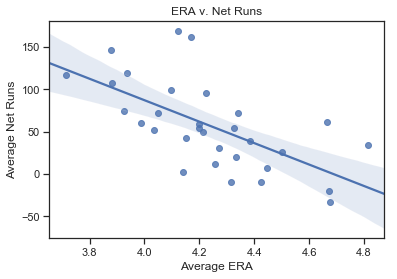

In [11]:
ax1 = sns.regplot('avg_era','avg_net_runs',data=df)
ax1.set(title = "ERA v. Net Runs", ylabel = "Average Net Runs", xlabel = "Average ERA")

df.describe()[1:]

From the scatterplot above we can see that there is a relationship between average era and net runs. This makes sense to us though, as average era is a measure of your ability not to let runs in. While not perfectly related, it gives us an idea of whether teams with great run differentials rely solely on their pitching staffs / hitters, or whether they take a more balanced approach. 

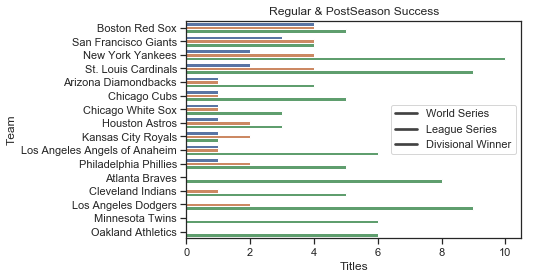

In [12]:
# get a list of teams that have won the division the most and the least over our time span. 
team_list = set(df['name'][:10]).union(set(df.sort_values(by='div_winner', ascending=False)['name'].values[:10]))
dfn = df[df['name'].isin(team_list)]
dfn = dfn[['name','ws_wins','lcs_wins','div_winner']].melt(id_vars='name',var_name='series',value_name='win_number')

ax = sns.barplot('win_number','name','series', data=dfn)
ax.set_title('Regular & PostSeason Success')
ax.set_ylabel('Team')
ax.set_xlabel('Titles')
ax.legend(labels=['World Series','League Series','Divisional Winner'])


Interestingly enough, it seem's  that regular season success (as measured by divison titles) isn't as indicitative of postseason success as one might have thought. The Braves, Dodgers, Twins, and Athletics all seem to have enjoyed a good measure of success over the past 15 or so years with no ultimate championship to show for it. In the Dodgers case, the past 5 or so years of no WS title is espeically noticeable as they, along with Boston, have jumped up in payroll expenditure to the level that the Yankee's previously solely occupied. 

It is also worth noting how teams from specific divisions seem to dominate the playoff success field. Boston and New York share the AL East. SF, LA, and AZ share the NL West, while the angels and A's share the AL West. 

Next, we look at trends in summary statistics over the past 18 years. These can give us an idea of which aspects of the game were valued during which era's. We can see the movenemt from the 'steroid slugger' age that ended in the 2000's, to the 'rise of the pitcher' in the late 2000's and early 2010's, to today's MLB where the long ball (but also the strike out) is making a comeback. 

In [13]:
team_statistics = pd.read_sql("""{}
SELECT year, AVG(ERA) AS avg_era, AVG(obp) AS avg_obp, AVG(walk_so) AS avg_walk_so, 
        AVG(hr_so) AS avg_hr_so, AVG(hra_ha) AS avg_hr_hits_allowed, AVG(hr_hit) AS avg_hr_hit
FROM q2
GROUP BY year
""".format(subquery),db)

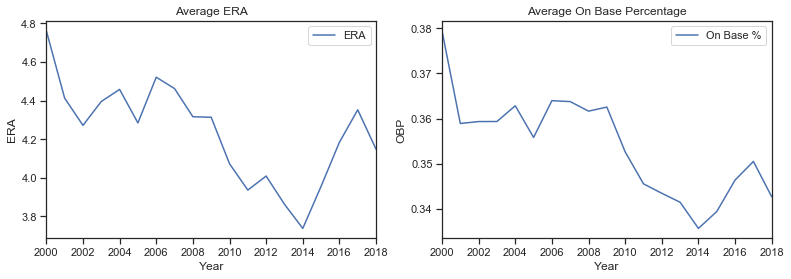

In [14]:
fig, ax = plt.subplots(1,2,figsize=(13,4))

team_statistics.plot('year','avg_era',ax=ax[0])
ax[0].set_title('Average ERA')
ax[0].set_ylabel('ERA')
ax[0].set_xlabel('Year')
ax[0].legend(labels=['ERA'])

team_statistics.plot('year','avg_obp',ax=ax[1])
ax[1].set_title('Average On Base Percentage')
ax[1].set_ylabel('OBP')
ax[1].set_xlabel('Year')
ax[1].legend(labels=['On Base %'])


ERA and OBP are related in that higher ERA implies that a pitching staff is letting in more runs which leads to the conclusion that more players are reaching base, either by walk or hit.  We see this play out in the graphs above, as the dip in ERA coincides with the dip in OBP, starting in 2010 and peaking during the 2014 season (aside: SF Giants won that year!!). Both metrics have climbed in recent years.

Links:

https://www.nytimes.com/2015/04/05/sports/baseball/baseball-2015-preview-in-a-pitching-rich-era-baseball-ponders-legal-ways-to-boost-offense.html

https://www.washingtonpost.com/news/fancy-stats/wp/2016/03/07/the-perfect-storm-that-created-baseballs-biggest-home-run-surge-since-the-steroid-era/?utm_term=.742e9f2ae12b

Text(0.5, 0, 'Year')

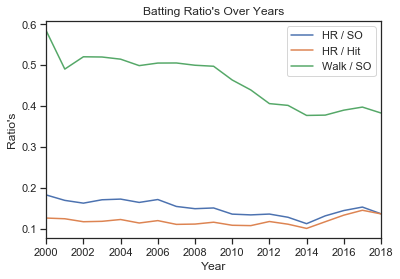

In [15]:
fig, ax = plt.subplots()
team_statistics.plot('year','avg_hr_so',ax=ax)
team_statistics.plot('year','avg_hr_hit',ax=ax)
team_statistics.plot('year','avg_walk_so',ax=ax)

ax.legend(labels=['HR / SO','HR / Hit','Walk / SO'])
ax.set_title("Batting Ratio's Over Years")
ax.set_ylabel("Ratio's")
ax.set_xlabel('Year')

We can see from the above illustration that the ratio of hr to strikeouts is converging to hr to hits. While this is occuring, the ratio of walks to strikeouts is falling as well. We can infer from this that players are focusing more and more on hitting home runs, at the cost of an increase in strikeouts, as opposed to being satisfied with singles, doubles, etc. While obviously valuable, a franchise could prioritize singles, double, and walks over huge hits with the idea that a run is a run , regardless of how you obtain it. 

Link:

https://www.washingtonpost.com/news/fancy-stats/wp/2018/05/04/mlb-batters-are-recording-more-strikeouts-than-hits-thats-a-big-problem-thats-unlikely-to-soon-change/?utm_term=.9ed257792240

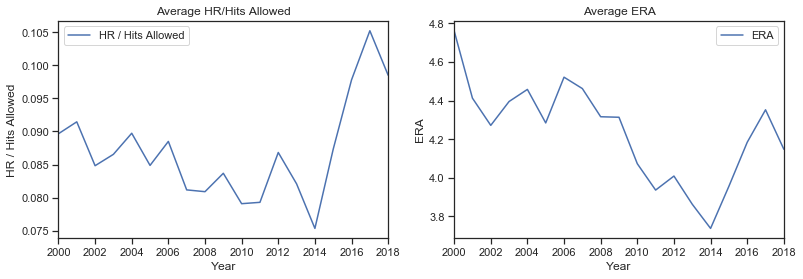

In [16]:
fig, ax = plt.subplots(1,2, figsize=(13,4))

team_statistics.plot('year','avg_hr_hits_allowed',ax=ax[0])
ax[0].set_title('Average HR/Hits Allowed')
ax[0].set_ylabel('HR / Hits Allowed')
ax[0].set_xlabel('Year')
ax[0].legend(labels=['HR / Hits Allowed'])

team_statistics.plot('year','avg_era',ax=ax[1])
ax[1].set_title('Average ERA')
ax[1].set_ylabel('ERA')
ax[1].set_xlabel('Year')
ax[1].legend(labels=['ERA'])

Looking at the average of home runs allowed versus teams ERA shows us that the recent spike in ERA looks very correlated with an increase in homeruns. We contrast this with the high ERA in the 2000's where the hr/hit ratio wasn't as high, reinforcing our findings above that player's focus has shifted from merely obtaining hits to focusing on home runs. 

Finally, we'll take a look at my hometown team, San Francisco, against the league average over the past 18 years. San Francisco exists in one of the larger markets and is in the top 10 payroll over this span of time. We will see if the team's trends followed the league at large, especially during the three years when they won World Series titles. 

In [17]:
sfg = pd.read_sql("""{}
SELECT sfg.*, nsf.avg_era, nsf.avg_obp, nsf.avg_walk_so, nsf.avg_hr_so, nsf.avg_hr_hits_allowed, nsf.avg_hr_hit FROM
    (SELECT year, AVG(ERA) AS avg_era_g, AVG(obp) AS avg_obp_g, AVG(walk_so) AS avg_walk_so_g, 
        AVG(hr_so) AS avg_hr_so_g, AVG(hra_ha) AS avg_hr_hits_allowed_g, AVG(hr_hit) AS avg_hr_hit_g
    FROM q3 GROUP BY year) as sfg
JOIN (SELECT year, AVG(ERA) AS avg_era, AVG(obp) AS avg_obp, AVG(walk_so) AS avg_walk_so, 
        AVG(hr_so) AS avg_hr_so, AVG(hra_ha) AS avg_hr_hits_allowed, AVG(hr_hit) AS avg_hr_hit
        FROM q4 GROUP BY year) as nsf
ON sfg.year = nsf.year ORDER BY year
""".format(subquery),db)

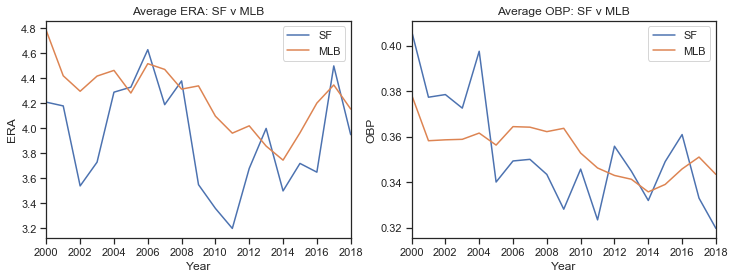

In [18]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

sfg.plot('year','avg_era_g',ax=ax[0])
sfg.plot('year','avg_era',ax=ax[0])
ax[0].set_title('Average ERA: SF v MLB')
ax[0].set_ylabel('ERA')
ax[0].set_xlabel('Year')
ax[0].legend(labels=['SF','MLB'])

sfg.plot('year','avg_obp_g',ax=ax[1])
sfg.plot('year','avg_obp',ax=ax[1])
ax[1].set_title('Average OBP: SF v MLB')
ax[1].set_ylabel('OBP')
ax[1].set_xlabel('Year')
ax[1].legend(labels=['SF','MLB'])

The story of SF's title runs from the turn of the century to present have depended on a mixture of offense, defense, and some postseason magic. In the early 2000's, SF went to the WS and lost to Anaheim, though this was the Barry Bonds & Jeff Kent team which was an offensive force, shown in the OBP above the average. But more noticeable is the ERA that is significantly below the league average, especially during the 3 runs that resulted in a Championship. From 2007-2012 the Giants staff was consistently one of the best in the league, headed by Tim Lincecum, Matt Cain, Barry Zito, and Madison Bumgarner. While these later teams OBP was roughly around league average, it was the pitching that propelled them to the title.

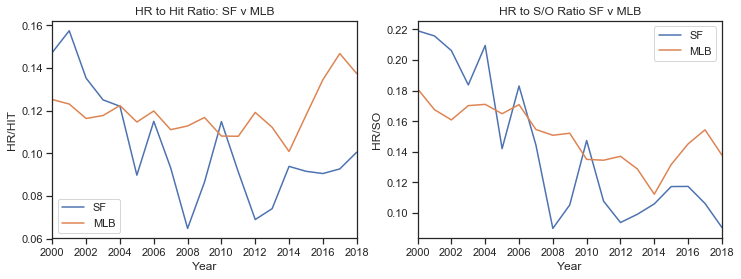

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

sfg.plot('year','avg_hr_hit_g',ax=ax[0])
sfg.plot('year','avg_hr_hit',ax=ax[0])
ax[0].set_title('HR to Hit Ratio: SF v MLB')
ax[0].set_ylabel('HR/HIT')
ax[0].set_xlabel('Year')
ax[0].legend(labels=['SF','MLB'])

sfg.plot('year','avg_hr_so_g',ax=ax[1])
sfg.plot('year','avg_hr_so',ax=ax[1])
ax[1].set_title('HR to S/O Ratio SF v MLB')
ax[1].set_ylabel('HR/SO')
ax[1].set_xlabel('Year')
ax[1].legend(labels=['SF','MLB'])

Next, looking at some offensive metrics gives us an idea of how the giants planned their runs in the later years. The early championship run for SF was marked by an awesoem offense. The team then dropped off, reaching lows in 2008. In 2010, SF's ratio was above the average, showing that the hitters were being more patient. This was a highlight of the style of play of the 2010, 12 and 14 championship teams. They were driven by an All-Star pitching staff, and adequate offense that didn't chase and wore the other teams pitchers out. 

This focus on pitching is one that clubs have seized upon and tweaked to the extent that clubs not prize pitching and bullpen talent over sluggers, as it has been shown that the team with the better staff in the postseason tend to have better outcomes.